In [ ]:
!pip install tensorboard
!pip install -qqq accelerate==0.28.0
!pip install -qqq transformers==4.48.3
!pip install -qqq datasets==3.6.0

!pip install -U accelerate

import os
from google.colab import drive

drive.mount('/content/drive')

zip_file = "/content/drive/MyDrive/ai_term/train.zip"
extract_dir = "data"
train_data_labels_path = os.path.join(extract_dir, "train", "train_labels.csv")

if not os.path.exists(extract_dir) or not os.path.exists(train_data_labels_path):
    print(f"{extract_dir} 디렉토리 또는 필요한 파일({train_data_labels_path})이 존재하지 않습니다. 압축 해제합니다.")
    if not os.path.exists(extract_dir):
        os.makedirs(extract_dir)
    !unzip -q {zip_file} -d {extract_dir}
else:
    print(f"{extract_dir} 디렉토리와 필요한 파일이 이미 존재합니다. 압축 해제를 건너뜁니다.")

train_data_labels = train_data_labels_path
train_image_path = os.path.join(extract_dir, "train", "images") + "/"

In [9]:
train_data_labels = "../data/train/train_labels.csv"
train_image_path = "../data/train/images/"

model_output_path = "./output"
train_output_path = "./output/train"

fruit_labels = ["apple", "asian pear", "banana", "cherry", "grape", "pineapple"]
style_labels = ["pencil color", "oil painting", "water color"]

In [10]:
from transformers import ViTImageProcessor
from transformers import Trainer, TrainingArguments
from transformers import ViTModel, PreTrainedModel, ViTConfig
import transformers as tf

from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import EarlyStoppingCallback

from datasets import Dataset
from datasets.features import Image

import torch.nn as nn
import torch

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

In [11]:
import os
import random

def set_seed(seed_value=42):
    """Set seed for reproducibility."""
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.mps.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()

In [12]:
def load_data(csv_path):
    df = pd.read_csv(csv_path)

    df['image'] = train_image_path + df['file_name']

    ds = Dataset.from_pandas(df)
    ds = ds.cast_column("image", Image())

    return ds

df = pd.read_csv(train_data_labels)

dataset = load_data(train_data_labels)

In [13]:
print(df.head())
print()
print(dataset)

  file_name  style  fruit
0     0.jpg      0      0
1     1.jpg      0      0
2     2.jpg      0      0
3     3.jpg      0      0
4     4.jpg      0      0

Dataset({
    features: ['file_name', 'style', 'fruit', 'image'],
    num_rows: 7200
})


In [14]:
feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")

def preprocess_images(examples):
    images = [feature_extractor(image.convert("RGB")) for image in examples["image"]]
    examples['pixel_values'] = [image['pixel_values'][0] for image in images]
    return examples

dataset = dataset.map(preprocess_images, batched=True)
formatted_dataset = dataset.select(range(len(dataset)))
formatted_dataset.set_format(type='torch', columns=['image', 'pixel_values', 'fruit', 'style'])

Map: 100%|██████████| 7200/7200 [00:56<00:00, 128.56 examples/s]


In [15]:
train_val_dataset = formatted_dataset.train_test_split(test_size=0.3, seed=42)
train_val = train_val_dataset["train"]
test = train_val_dataset["test"]

train_val = train_val.train_test_split(test_size=0.2, seed=42)
train = train_val["train"]
val = train_val["test"]

In [16]:
class MultiTaskViTConfig(ViTConfig):
    def __init__(self, num_fruit=6, num_style=3, **kwargs):
        super().__init__(**kwargs)
        self.num_fruit = num_fruit
        self.num_style = num_style

class MultiTaskViT(PreTrainedModel):
    config_class = MultiTaskViTConfig

    def __init__(self, config):
        super().__init__(config)

        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        hidden_size = self.vit.config.hidden_size

        self.fruit_classifier = nn.Linear(hidden_size, config.num_fruit)
        self.style_classifier = nn.Linear(hidden_size, config.num_style)

    def forward(self, pixel_values, fruit=None, style=None, **kwargs):
        outputs = self.vit(pixel_values=pixel_values)
        pooled_output = outputs.pooler_output


        fruit_logits = self.fruit_classifier(pooled_output)
        style_logits = self.style_classifier(pooled_output)

        loss = None
        if fruit is not None and style is not None:
            loss_fn = nn.CrossEntropyLoss()
            fruit_loss = loss_fn(fruit_logits, fruit)
            style_loss = loss_fn(style_logits, style)
            loss = fruit_loss + style_loss

        return SequenceClassifierOutput(
            loss=loss,
            logits=(fruit_logits, style_logits),
        )

In [35]:
train_epoch = 3
learning_rate = 2e-5
batch_size = 16
weight_decay = 0.05

warmup_ratio = 0.1

lr_scheduler_type = "cosine"

gradient_accumulation_steps = 1

In [36]:
num_fruit = len(set(dataset["fruit"]))
num_style = len(set(dataset["style"]))

print("num_fruit: ", num_fruit)
print("num_style: ", num_style)

base_config = ViTConfig.from_pretrained("google/vit-base-patch16-224-in21k")

config = MultiTaskViTConfig(
    **base_config.to_dict(),
    num_fruit=num_fruit,
    num_style=num_style
)

model = MultiTaskViT(config=config)

num_fruit:  6
num_style:  3


In [37]:
training_args = TrainingArguments(
    output_dir=train_output_path,
    eval_strategy="epoch",
    save_strategy="epoch",                 
    logging_strategy="epoch",
    learning_rate=learning_rate,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=train_epoch,
    weight_decay=weight_decay,
    logging_dir='./logs',
    report_to=["tensorboard"],
    label_names=["fruit", "style"],
    fp16=False,
    warmup_ratio=warmup_ratio,
    lr_scheduler_type=lr_scheduler_type,
    gradient_accumulation_steps=gradient_accumulation_steps,
    load_best_model_at_end=True,
    metric_for_best_model="mean_f1",
    greater_is_better=True,
)

def compute_metrics(eval_pred):
    fruit_logits, style_logits = eval_pred.predictions

    fruit_labels, style_labels = eval_pred.label_ids

    fruit_predictions = np.argmax(fruit_logits, axis=-1)
    style_predictions = np.argmax(style_logits, axis=-1)

    fruit_precision, fruit_recall, fruit_f1, _ = precision_recall_fscore_support(fruit_labels, fruit_predictions,
                                                               average='weighted')
    fruit_acc = accuracy_score(fruit_labels, fruit_predictions)

    style_precision, style_recall, style_f1, _ = precision_recall_fscore_support(style_labels, style_predictions,
                                                               average='weighted')
    style_acc = accuracy_score(style_labels, style_predictions)

    mean_f1 = (fruit_f1 + style_f1) / 2

    return {"fruit_acc": fruit_acc, "fruit_precision": fruit_precision, "fruit_recall": fruit_recall, "fruit_f1": fruit_f1,
            "style_acc": style_acc, "style_precision": style_precision, "style_recall": style_recall, "style_f1": style_f1,
            "mean_f1": mean_f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset=val,
    compute_metrics=compute_metrics,
)

In [38]:
trainer.train()

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Epoch,Training Loss,Validation Loss,Fruit Acc,Fruit Precision,Fruit Recall,Fruit F1,Style Acc,Style Precision,Style Recall,Style F1,Mean F1
1,1.124800,0.113420,0.999008,0.999013,0.999008,0.999008,0.997024,0.997038,0.997024,0.997020,0.998014
2,0.060100,0.044049,1.000000,1.000000,1.000000,1.000000,0.999008,0.999011,0.999008,0.999008,0.999504
3,0.031200,0.038621,1.000000,1.000000,1.000000,1.000000,0.999008,0.999011,0.999008,0.999008,0.999504


/opt/homebrew/anaconda3/envs/ai311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/opt/homebrew/anaconda3/envs/ai311/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=756, training_loss=0.40536570044421644, metrics={'train_runtime': 362.6158, 'train_samples_per_second': 33.358, 'train_steps_per_second': 2.085, 'total_flos': 0.0, 'train_loss': 0.40536570044421644, 'epoch': 3.0})

In [39]:
model.save_pretrained(model_output_path)

feature_extractor.save_pretrained(model_output_path)

['./output/preprocessor_config.json']

In [40]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

extractor = ViTImageProcessor.from_pretrained(model_output_path)
model = MultiTaskViT.from_pretrained(model_output_path).to(device).eval()

Using device: mps


/opt/homebrew/anaconda3/envs/ai311/lib/python3.11/site-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [41]:
test['image'].shape

torch.Size([2160, 3, 512, 512])

In [42]:
from PIL import Image
import torchvision.transforms.functional as TF
from tqdm import tqdm

pred_fruit, pred_style = [], []
true_fruit, true_style = [], []

for item in tqdm(test):
    image = TF.to_pil_image(item['image'])

    inputs = feature_extractor(images=image, return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)

    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
        fruit_logits, style_logits = outputs.logits

        fruit_pred = torch.argmax(fruit_logits, dim=-1).item()
        style_pred = torch.argmax(style_logits, dim=-1).item()

    pred_fruit.append(fruit_pred)
    pred_style.append(style_pred)
    true_fruit.append(item['fruit'].item())
    true_style.append(item['style'].item())

def report(task_name, y_true, y_pred):
    print(f"[{task_name}]")
    print(f"  Accuracy : {accuracy_score(y_true, y_pred):.4f}")
    print(f"  Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"  Recall   : {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"  F1 Score : {f1_score(y_true, y_pred, average='macro'):.4f}\n")

report("Fruit", true_fruit, pred_fruit)
report("Style", true_style, pred_style)

100%|██████████| 2160/2160 [01:05<00:00, 32.99it/s]

[Fruit]
  Accuracy : 0.9986
  Precision: 0.9986
  Recall   : 0.9987
  F1 Score : 0.9986

[Style]
  Accuracy : 0.9986
  Precision: 0.9986
  Recall   : 0.9986
  F1 Score : 0.9986



In [43]:
def draw_two_confusion_matrix(first_label, first_conf_matrix, first_classes, second_label, second_conf_matrix, second_classes):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.heatmap(first_conf_matrix, annot=True, fmt="d", cmap="YlGnBu",
                xticklabels=first_classes, yticklabels=first_classes, ax=axes[0])
    axes[0].set_title(f"Confusion Matrix: {first_label}")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    sns.heatmap(second_conf_matrix, annot=True, fmt="d", cmap="YlOrBr",
                xticklabels=second_classes, yticklabels=second_classes, ax=axes[1])
    axes[1].set_title(f"Confusion Matrix: {second_label}")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")

    plt.tight_layout()
    plt.show()

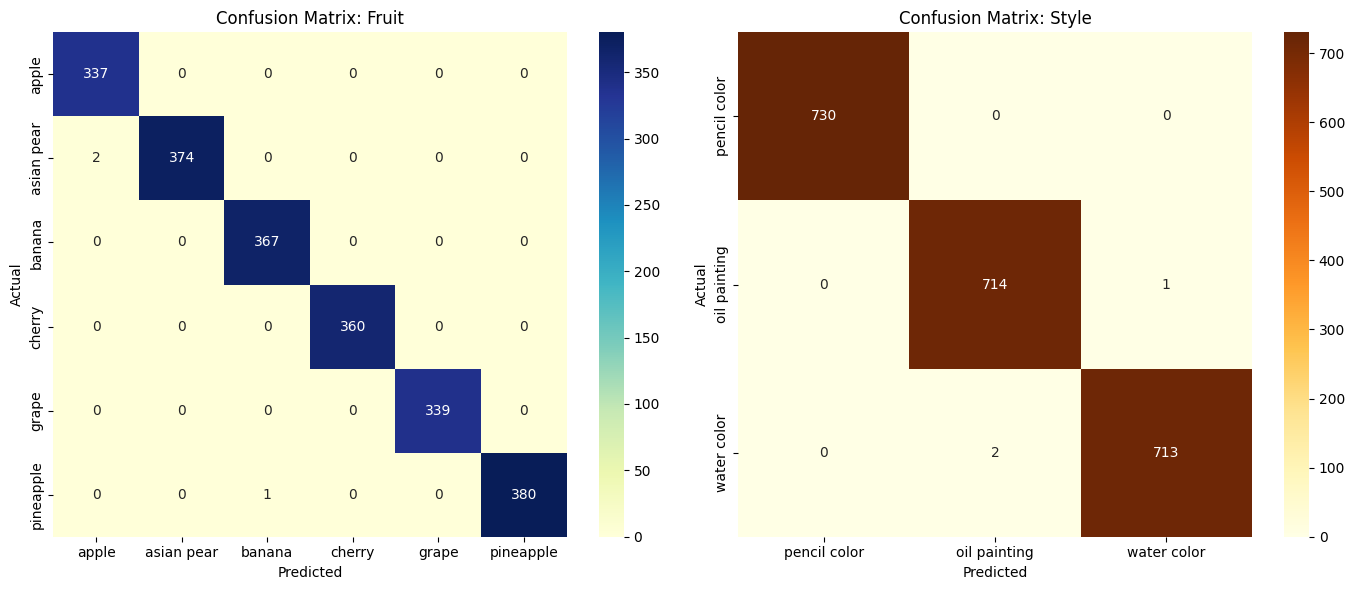

In [44]:
def map_labels(int_labels, label_names):
    return [label_names[i] for i in sorted(set(int_labels))]

fruit_classes = map_labels(dataset["fruit"], fruit_labels)
style_classes = map_labels(dataset["style"], style_labels)

fruit_conf_matrix = confusion_matrix(true_fruit, pred_fruit)
style_conf_matrix = confusion_matrix(true_style, pred_style)

draw_two_confusion_matrix("Fruit", fruit_conf_matrix, fruit_classes, "Style", style_conf_matrix, style_classes)